.. index::
   pair: I/O; Backup/Restore

# Backup and restore (pickling)
We show here how the state of a simulation can be stored and restored
using pickle. This is still work in progress and based on an extension
of the standard `pickle` module available in `dune.common`:

In [1]:
import dune.common.pickle

Let's first construct a grid and some discrete function:

In [2]:
import numpy
from dune.alugrid import aluConformGrid
from dune.fem.view import adaptiveLeafGridView as view
from dune.grid import cartesianDomain, Marker
from dune.fem.function import gridFunction
from dune.fem.space import lagrange
from dune.fem import gridAdapt
from dune.ufl import Constant
import ufl

order = 4
def setup():
    gridView = view( aluConformGrid( cartesianDomain([-2,-2],[2,2],[10,10]) ) )

    @gridFunction(gridView, name="gf", order=3)
    def gf(x): return numpy.sqrt(1-(x[0]**2+x[1]**2)) if x[0]**2+x[1]**2<1 else 0

    space = lagrange(gridView, order=order)
    df = space.interpolate(gf,name="test")

    gridView.hierarchicalGrid.globalRefine(4)
    marker = lambda e: Marker.refine if df.localFunction(e).jacobian([1./3.,1./3.]).infinity_norm > 1 else Marker.coarsen
    for i in range(5):
        gridAdapt(marker, gridView.hierarchicalGrid)
        df.interpolate( gf )
    print("size of adapted grid view:", gridView.size(0))

    t = Constant(0,"time")
    x = ufl.SpatialCoordinate(space)
    gf = gridFunction(ufl.tanh(2*(t*x[0]-x[1]))*ufl.dot(x,x),
                     gridView,order=2,name="tanh")
    return df, space.interpolate(gf,name="tanh_h"),gf

## Pickling
.. index:: I/O; Pickling

`dune.common` provides a `pickle` module with a similar functionality
as Python `pickle`. In fact `pickle.dump` can be used to (un)pickle many
`dune` objects. The `dune.common.pickle` module adds the JIT generation
of modules on load so that pickled data can be recreated on machines
where these JIT modules have not yet been generated. In addition an
`dune.common.pickle.SeriesPickler` is available which can for example
be used to pickle time series data.

Let's first write a function that dumps some discrete functions:

In [3]:
def dump():
    df1, df2, gf = setup()

    with open("test.dbf","wb") as f:
        dune.common.pickle.dump([df1,df2],f)

    series = dune.common.pickle.SeriesPickler("test", objects=[df1,df2])

    tsps = [0,0.4,0.8,1.2,2.5,5]
    def inCircle(p,t):
        p -= [numpy.cos(t),numpy.sin(t)]
        return p.two_norm < 0.3
    for i,tsp in enumerate(tsps):
        marker = lambda e: Marker.refine if inCircle(e.geometry.center,tsp) else Marker.keep
        for i in range(3):
            gridAdapt(marker, [df1,df2])
        gf.time = tsp
        df2.interpolate(gf)
        series.dump({"time":tsp})
dump()

size of adapted grid view: 4288


Now we can reconstructed the data again:

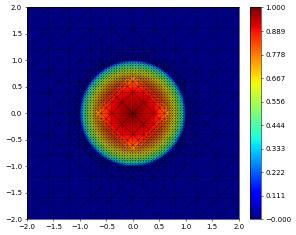

{'time': 0, 'dumpFileName': 'test.000000.dbf'}


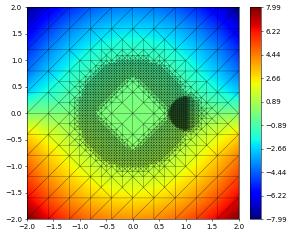

{'time': 0.4, 'dumpFileName': 'test.000001.dbf'}


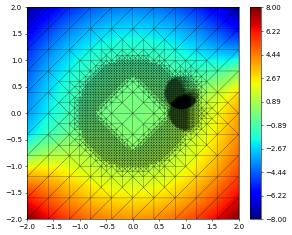

{'time': 0.8, 'dumpFileName': 'test.000002.dbf'}


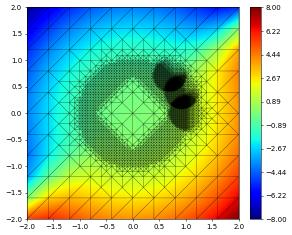

{'time': 1.2, 'dumpFileName': 'test.000003.dbf'}


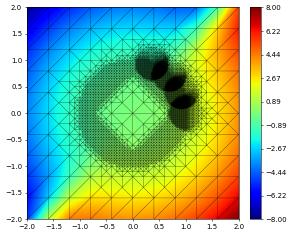

{'time': 2.5, 'dumpFileName': 'test.000004.dbf'}


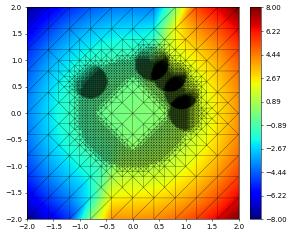

{'time': 5, 'dumpFileName': 'test.000005.dbf'}


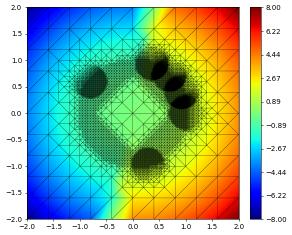

In [4]:
with open("test.dbf","rb") as f:
    df1,df2 = dune.common.pickle.load(f)
df1.plot()

series = dune.common.pickle.SeriesPickler("test")
while True:
    try:
        data, df = series.load()
    except FileNotFoundError:
        break
    print(data)
    df[1].plot()

## A Chekpointer class
.. index:: I/O; Checkpointing

In the code below, we implement a class that stores a hierarchical grid and some discrete
functions and other information and can serve a starting point for
pickling data for complex simulations. This example relies on the
original `pickle` module.

In [5]:
import pickle
class CheckPointer:
    # if 'gridView=None' then restore grid view using given file name
    # otherwise backup 'gridView' to given file
    def __init__(self,fileName,gridView=None):
        if gridView is None: # restore file
            self.file = open(fileName,'rb')
            self.gridView = pickle.load(self.file)
        else:             # store file
            self.file = open(fileName,'wb')
            self.gridView = gridView
            pickle.dump(self.gridView,self.file)
        self.items = []

    # add an item to pickle when backup is called (or restore)
    def add(self,item):
        assert hasattr(item,"write") and hasattr(item,"read")
        self.items += [item]

    def backup(self):
        pickle.dump([i.write() for i in self.items], self.file)
    def restore(self):
        for i,d in zip(self.items, pickle.load(self.file)):
            i.read(d)

First test: construct the grid view, some discrete function, and refine the mesh.
The result is then store in a file.

In [6]:
def test1(fileName):
    df1, df2,_ = setup()
    checkPointer = CheckPointer(fileName, df1.gridView)
    checkPointer.add(df1)
    checkPointer.add(df2)
    checkPointer.backup()

test1("dump.pickle")

size of adapted grid view: 4288


Now we restore the backup

size of restored grid view: 4288


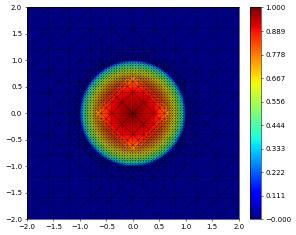

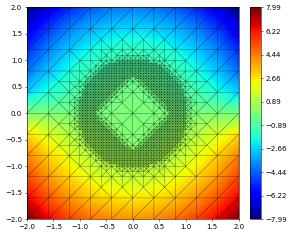

In [7]:
checkPointer = CheckPointer("dump.pickle")
gridView = checkPointer.gridView
print("size of restored grid view:", gridView.size(0))
space = lagrange(gridView, order=order)
df1 = space.function(name="test")
df2 = space.function(name="test")
checkPointer.add(df1)
checkPointer.add(df2)
checkPointer.restore()
df1.plot()
df2.plot()